In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Fractional power of Matrix

In [2]:
def GetInterval(A,Ainv,beta,eps=10**-15):
    normA  = np.linalg.norm(A)
    normAi = np.linalg.norm(Ainv)
    # compute a
    c  = beta*math.pi
    a1 = (c*(1+beta)*eps)/(4*math.sin(c)*(1+2*beta))
    a2 = (2*normAi)**-beta
    a  = min(a1,a2)
    # compute b
    d  = beta/(beta-1)
    e  = (1-beta)*math.pi
    b1 = (e*(2-beta)*eps)**d/(4*math.sin(c)*(3-2*beta)*normA)**d
    b2 = (2*normA)**beta
    b  = max(b1,b2)
    # compute interval [l,r]
    l = math.asinh(2*math.log(a)/c)
    r = math.asinh(2*math.log(b)/c)
    return l, r

In [3]:
def FDE(x,A,beta):
    nx     = A.shape[0]
    try:
        f0  = math.exp((beta-1)*math.pi*math.sinh(x)/2)
    except OverflowError:
        f0  = float('inf')
    try:
        f1  = math.exp(math.pi*math.sinh(x)/2)
    except OverflowError:
        f1  = float('inf')
    try:
        f2 = math.cosh(x)
    except OverflowError:
        f2 = float('inf')
    M      = f0*f2*np.linalg.inv(np.eye(nx)+1/f1*A)
    return M

In [4]:
def Adaptative_Quad_DE(A,Ainv,beta,eps=10**-5,niter=5):
    l,r = GetInterval(A,Ainv,beta,eps)
    m   = 8
    h   = (r-l)/(m-1)
    g   = math.sin(beta*math.pi)/2
    # compute T
    T   = h*(FDE(l,A,beta)+FDE(r,A,beta))/2
    for k in range(1,m-1):
        T += h*FDE(l+k*h,A,beta)
    Told = T.copy() 
    # compute quadrature
    for s in range(niter):
        h = h/2
        T = T/2
        for k in range(1,m-1):
            T += h*FDE(l+(2*k-1)*h,A,beta)
        m = 2*m-1
        # test if precision is obtained
        err = g*np.linalg.norm(A.dot(T)-A.dot(Told))
        if abs(err)<eps/2:
            return g*A.dot(T)
        Told = T.copy()
    # return
    return g*A.dot(T)  

In [23]:
nx = 100 # signal size
dx = 1/nx
# B et B^-1 = tTT
T = dx*np.tri(nx)
tTT = T.transpose().dot(T)
B = 2*dx**-2*np.diag(np.ones(nx))\
    - dx**-2*np.diag(np.ones(nx-1),1)\
    - dx**-2*np.diag(np.ones(nx-1),-1)
B[0,0]= dx**-2

### Test pour la fonction identité

In [24]:
# test 1
GetInterval(np.eye(nx),np.eye(nx),0.5,eps=10**-5)

(-3.480040298887228, 3.6459668638568092)

In [25]:
beta = 0.5
D = Adaptative_Quad_DE(np.eye(nx),np.eye(nx),beta,niter=10)

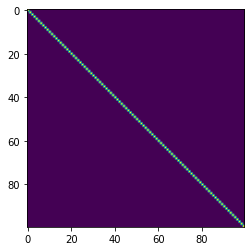

In [26]:
plt.imshow(D)

In [27]:
np.linalg.norm(D.dot(D)-np.eye(nx))/np.linalg.norm(np.eye(nx))

5.712188678064223e-06

### Test pour B

In [28]:
beta = 0.5
D = Adaptative_Quad_DE(B,tTT,beta,eps=10**-10,niter=15)

In [29]:
np.linalg.norm(D.dot(D)-B)/np.linalg.norm(B)

4.634861324402314e-10

### Test pour T_a

In [30]:
a  = 0.5
Ta = Adaptative_Quad_DE(T,np.linalg.inv(T),beta,eps=10**-10,niter=15)

In [31]:
# Synthetic Data
t   = np.linspace(0,1-1/nx,nx)
x   = np.exp(-(t-0.5)**2/0.1**2)
x   = x/np.amax(x)
y   = Ta.dot(x)

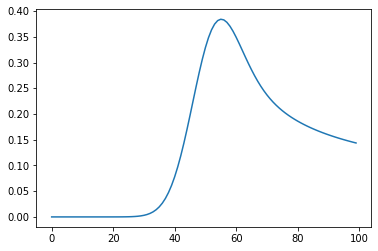

In [32]:
plt.plot(y)

In [33]:
Ta

array([[0.1       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05      , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0375    , 0.05      , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0057211 , 0.00575074, 0.00578085, ..., 0.1       , 0.        ,
        0.        ],
       [0.00569191, 0.0057211 , 0.00575074, ..., 0.05      , 0.1       ,
        0.        ],
       [0.00566316, 0.00569191, 0.0057211 , ..., 0.0375    , 0.05      ,
        0.1       ]])

In [36]:
Tb = np.zeros((nx,nx))
for i in range(nx):
    for j in range(nx):
        if j<=i:
            Tb[i,j]=1/(2*a)*dx**(a)*((i-j+1)**a-(i-j)**a)

In [37]:
Tb

array([[0.1       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04142136, 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03178372, 0.04142136, 0.1       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00506371, 0.00508988, 0.00511646, ..., 0.1       , 0.        ,
        0.        ],
       [0.00503794, 0.00506371, 0.00508988, ..., 0.04142136, 0.1       ,
        0.        ],
       [0.00501256, 0.00503794, 0.00506371, ..., 0.03178372, 0.04142136,
        0.1       ]])